## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
device = 'cuda'

## Create a Torch.Dataset class for the training dataset

In [7]:
from glob import glob
import pickle5
import numpy as np

ROOT_PATH = "C:/Users/Administrator/cse151b-spring2022/argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle5.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle5.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return torch.from_numpy(inputs).float(), torch.from_numpy(outputs).long()

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, device='cuda'):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        self.inputs = self.inputs.to(device)
        self.outputs = self.outputs.to(device)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [8]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [11]:
train_loader.dataset[0]

(tensor([[-1303.7626,  1138.3125],
         [-1303.5175,  1138.7170],
         [-1303.2120,  1139.2190],
         [-1302.8483,  1139.8162],
         [-1302.4299,  1140.5007],
         [-1301.9619,  1141.2626],
         [-1301.4559,  1142.0831],
         [-1300.9259,  1142.9409],
         [-1300.3829,  1143.8174],
         [-1299.8369,  1144.6935],
         [-1299.3031,  1145.5436],
         [-1298.7831,  1146.3669],
         [-1298.2632,  1147.1887],
         [-1297.7430,  1148.0062],
         [-1297.2236,  1148.8143],
         [-1296.7057,  1149.6149],
         [-1296.1882,  1150.4121],
         [-1295.6709,  1151.2047],
         [-1295.1528,  1151.9935],
         [-1294.6350,  1152.7781],
         [-1294.1199,  1153.5569],
         [-1293.6080,  1154.3318],
         [-1293.1000,  1155.1016],
         [-1292.5939,  1155.8668],
         [-1292.0916,  1156.6260],
         [-1291.5912,  1157.3821],
         [-1291.0872,  1158.1421],
         [-1290.5769,  1158.9077],
         [-1290.0631

In [30]:
epochs = 20
hidden_size = 32
lr = 0.1
MAX_LENGTH = 50

In [31]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, input):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).float().to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).float().to(device)
        
        input = input.reshape([4, 2, 50])
        out, _ = self.lstm(input, (h0, c0))
        print('accomplished')
        out = out.reshape(out.shape[0], -1)
        #embedded = self.embedding(input).view(1, 1, -1)
        print('output:', out.shape, out.dtype)
        return out

    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)


In [32]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        print('input:', input.dtype, input.shape)
        #output = self.embedding(input).view(1, 1, -1)
        #output = F.relu(input)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [35]:
encoder = EncoderRNN(input_size=50, hidden_size=hidden_size)
encoder.to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

In [36]:
criterion = nn.NLLLoss()
epochs = 10
losses = []
for epoch in range(epochs):
    for x, y in train_loader:
        print(x[0].shape)
        print(x.dtype)
        print(y.dtype)
        encoder.train()
        optimizer.zero_grad()
        outputs = encoder(x)
        
        train_loss = criterion(outputs, y)
        train_loss.backward()
        optimizer.step()

    losses.append(float(train_loss.item()))    
    if epoch % 10 == 0:
        print(f'epoch {epoch}, loss: {train_loss.item()}')

torch.Size([50, 2])
torch.float32
torch.int64
input: torch.float32 torch.Size([4, 50, 2])
h0: torch.float32 torch.Size([1, 4, 32])
c0: torch.float32 torch.Size([1, 4, 32])
accomplished
output: torch.Size([4, 64]) torch.float32


RuntimeError: multi-target not supported at C:/w/b/windows/pytorch/aten/src\THCUNN/generic/ClassNLLCriterion.cu:15

## Sample a batch of data and visualize 

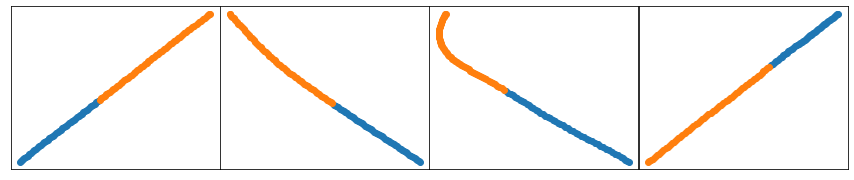

In [ ]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

In [ ]:
len(train_loader.dataset[0][0])

50